HW5 - Fake News Detection 2
本次作業同HW4針對假新聞作分析，預測一則新聞是否reliable (繳交期限：12/17 23:55)
資料集共有兩個:
1: fake
0: true
請分別利用RNN與LSTM對"train.csv"的資料建模，對"test.csv"測試計算Accuracy
可使用Keras(建議)或Tensorflow來完成本次作業
註："test.csv"的label在"sample_submission.csv"裡面

作業流程: 

1. 資料前處理(可延用HW4之方法)：
a. 讀取資料，利用分割符號切割字串、建立train&test之DataFrame
b. 去除停頓詞
c. 文字轉向量（Tfidf 、Ｗord2vec …等 ）

2. 建模
a. 分別用RNN與LSTM對train.csv的資料進行建模，可自行設計神經網路的架構
b. 加入Dropout Layer設定Dropout參數(建議0.7)進行比較
c. plot出訓練過程中的Accuracy與Loss值變化

3. 評估模型
a. 利用"text.csv"的資料對2.所建立的模型進行測試，並計算Accuracy

請將以下檔案壓縮成 HW5_學號_姓名.zip：
1. 討論報告PDF (含截圖跟簡短說明、討論等等)
2. Python程式

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv", sep='\t', encoding='utf-8')
test = pd.read_csv("test.csv", sep='\t', encoding='utf-8')

train.head()

# type(train) : pandas.core.frame.DataFrame
# train.columns : Index(['text', 'label'], dtype='object')
# print( len(train['text'])): 4987
# print(len(test['text'])): 1247

,text,label
0,Get the latest from TODAY Sign up for our news...,1
1,2d Conan On The Funeral Trump Will Be Invited...,1
2,It’s safe to say that Instagram Stories has fa...,0
3,Much like a certain Amazon goddess with a lass...,0
4,At a time when the perfect outfit is just one ...,0


In [2]:
test_label = pd.read_csv("sample_submission.csv")
test_label

,id,label
0,2,1
1,3,1
2,4,0
3,5,0
4,6,0
...,...,...
1242,1244,0
1243,1245,0
1244,1246,1
1245,1247,1


In [3]:
test_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      1247 non-null   int64
 1   label   1247 non-null   int64
dtypes: int64(2)
memory usage: 19.6 KB


In [4]:
train["text"][0]

'Get the latest from TODAY Sign up for our newsletter  No one ever truly gets over losing a loved one, and Blake Shelton is no exception. He was just 14 when his older brother Richie died on Nov. 13, 1990. And, as Shelton noted in a tweet Monday, "It changed my life forever."  Richie was 24 when he died in a car accident in the Sheltons\' home state of Oklahoma. Two years ago, Shelton sent out a message for the 25th anniversary of his loss:  Richie, who was Blake\'s half-brother (they shared a mother), was a passenger in a car that collided with a school bus in Ada, south of Oklahoma City.  Richie, driver Redena McManus and a 3-year-old boy, Christopher McManus, all died during or shortly after the collision, while the bus driver and passengers were uninjured, according to police reports.  The accident has clearly remained with Blake, who told 60 Minutes in 2014, "I remember picking up the phone to call him a week after he was dead, to tell him something. I was picking up the phone to 

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4987 entries, 0 to 4986
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4987 non-null   object
 1   label   4987 non-null   object
dtypes: object(2)
memory usage: 78.0+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1247 non-null   int64 
 1   text    1247 non-null   object
dtypes: int64(1), object(1)
memory usage: 19.6+ KB


In [7]:
# 有個 label夾在0.1裡面，抓出來刪掉row1615
# train["label"].value_counts()
# 0        2972
# 1        2014
# label       1
# Name: label, dtype: int64


# a=0
# for i in train["label"]:
#     if i!="label":
#         a+=1
#     if i=="label":
#         break
# a=1615
train = train.drop([1615])

In [8]:
train["label"].value_counts()

0    2972
1    2014
Name: label, dtype: int64

In [9]:
int(train["label"][0])

1

In [10]:
# make y int
y_train = []
for i in train["label"]:
    a = int(i)
    y_train.append(a)

y_train = np.array(y_train)

In [11]:
# scikit learn的vecrizor+tfidftransformer 的方法做文字-數字化-向量化的結果放到模型會出現Error，但是用林大貴書內的方法擇可以順利套用模型，因此使用：
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

token = Tokenizer(num_words=3800)
token.fit_on_texts(train["text"])


In [12]:
x_train_seq = token.texts_to_sequences(train["text"])
x_test_seq  = token.texts_to_sequences(test["text"])

In [13]:
x_train = sequence.pad_sequences(x_train_seq, maxlen=380)
x_test  = sequence.pad_sequences(x_test_seq,  maxlen=380)

# 建立RNN模型

In [14]:
"""
RNN
"""
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN

model = Sequential()

# Embedding: ransfer number_lists into vector_lists
model.add(Embedding(output_dim=32,     # 32-vectorize
                    input_dim=3800,    # 3800 words in token.dictionary
                    input_length=380)) # x_train_maxlen=100
model.add(Dropout(0.7))                # drop 70% of nurons in each epoch, to prevent overfitting

model.add(SimpleRNN(units=16))

# hidden layer
model.add(Dense(units=256, activation='relu' ))
model.add(Dropout(0.7))


# output layer
model.add(Dense(units=1, activation='sigmoid' ))

# check the model
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 380, 32)           121600    
_________________________________________________________________
dropout (Dropout)            (None, 380, 32)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 16)                784       
_________________________________________________________________
dense (Dense)                (None, 256)               4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 126,993
Trainable params: 126,993
Non-trainable params: 0
__________________________________________________

# 訓練RNN模型

In [15]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [16]:
train_history =model.fit(x_train, y_train,batch_size=100, 
                         epochs=10,verbose=2,)
                         #validation_split=0.2)

Epoch 1/10
50/50 - 9s - loss: 0.6793 - accuracy: 0.5852
Epoch 2/10
50/50 - 9s - loss: 0.6702 - accuracy: 0.5981
Epoch 3/10
50/50 - 9s - loss: 0.6498 - accuracy: 0.6145
Epoch 4/10
50/50 - 9s - loss: 0.6017 - accuracy: 0.6797
Epoch 5/10
50/50 - 9s - loss: 0.5329 - accuracy: 0.7349
Epoch 6/10
50/50 - 9s - loss: 0.4575 - accuracy: 0.7894
Epoch 7/10
50/50 - 8s - loss: 0.3884 - accuracy: 0.8265
Epoch 8/10
50/50 - 8s - loss: 0.3328 - accuracy: 0.8596
Epoch 9/10
50/50 - 9s - loss: 0.3098 - accuracy: 0.8702
Epoch 10/10
50/50 - 8s - loss: 0.2692 - accuracy: 0.8913


In [25]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,loss):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[loss])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'loss'], loc='upper left')
    plt.show()

In [ ]:
show_train_history(train_history,'accuracy','loss')

# 建立LSTM模型

In [20]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM

In [21]:
model = Sequential()

model.add(Embedding(output_dim=32,
                    input_dim=3800, 
                    input_length=380))
model.add(Dropout(0.2))

model.add(LSTM(32))

model.add(Dense(units=256,
                activation='relu' ))
model.add(Dropout(0.2))

model.add(Dense(units=1,
                activation='sigmoid' ))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 380, 32)           121600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 380, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 138,625
Trainable params: 138,625
Non-trainable params: 0
________________________________________________

# 訓練LSTM模型

In [22]:
model.compile(loss='binary_crossentropy', 
              #optimizer='rmsprop', 
              optimizer='adam', 
              metrics=['accuracy'])

In [23]:
train_history_lstm =model.fit(x_train, y_train,batch_size=100, 
                             epochs=10,verbose=2,)
                             #validation_split=0.2)

Epoch 1/10
50/50 - 1s - loss: 0.6762 - accuracy: 0.5953
Epoch 2/10
50/50 - 1s - loss: 0.5985 - accuracy: 0.6735
Epoch 3/10
50/50 - 1s - loss: 0.4470 - accuracy: 0.7930
Epoch 4/10
50/50 - 1s - loss: 0.3449 - accuracy: 0.8592
Epoch 5/10
50/50 - 1s - loss: 0.2771 - accuracy: 0.8917
Epoch 6/10
50/50 - 1s - loss: 0.2119 - accuracy: 0.9260
Epoch 7/10
50/50 - 1s - loss: 0.1640 - accuracy: 0.9454
Epoch 8/10
50/50 - 1s - loss: 0.1340 - accuracy: 0.9557
Epoch 9/10
50/50 - 1s - loss: 0.1073 - accuracy: 0.9623
Epoch 10/10
50/50 - 1s - loss: 0.0900 - accuracy: 0.9695


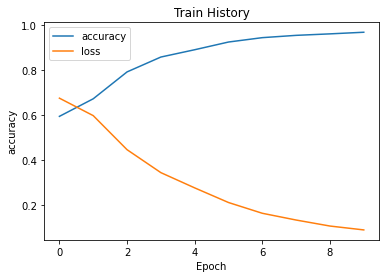

In [26]:
# use def above
show_train_history(train_history_lstm,'accuracy','loss')